<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import random

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
from os import listdir
from os.path import isfile, join

dummy_site = 0

# строим список данных одной сессии
def session_features(sites, times, n_from, n_to):
    # сайты
    session = sites[n_from:n_to]
        
    # дополнительные признаки
    time_diffs = [int((t2 - t1).total_seconds()) for t1, t2 in zip(times[n_from:n_to-1], times[n_from+1:n_to])]
    session_timespan = int((times[n_to-1] - times[n_from]).total_seconds())
    unique_sites = len(set(session)) - (1 if session[-1] == 0 else 0) # исключаем ноль, если есть (а нули всегда в конце)
    start_hour = times[n_from].hour
    day_of_week = times[n_from].dayofweek

    session.extend(time_diffs)
    session.extend([session_timespan, unique_sites, start_hour, day_of_week])

    return session


# обработка содержимого одного файла, добавляет элементы в общий список сессий session_list
def get_sessions_from(lines, session_list, fdict, session_length, window_size, user_id, 
                      get_session_func):
    
    # Разобрать строки файла. Не используем pandas.read_csv() потому что медленно.
    sites = []
    times = []
    for row in lines[1:]:
        site = row[20:-1] # сайт c 20-й позиции, и убираем /n в конце строки
        ts =  pd.to_datetime(row[:19], format='%Y-%m-%d %H:%M:%S')   # пример: 2013-11-15 09:28:17
        siteinfo = fdict[site]     # номер сайта берем из ранее собранного словаря
        site_index = siteinfo[0]
        
        sites.append(site_index)
        times.append(ts)
        
    n_sites = len(sites)
    sites.extend([dummy_site] * session_length)  # в конце списка сайтов нули чтобы не думать
    times.extend([times[-1]] * session_length)   # и аналогично в конце штампы времени с нулевой разницей от последнего
    n_end = len(sites)
    
    starts = range(0, n_sites, window_size)           # индексы начала сессий - через каждые window_size элементов
    ends = range(session_length, n_end, window_size)  # индексы конца сессий

    # формируем данные сессий
    for n_from, n_to in zip(starts, ends):
        session = get_session_func(sites, times, n_from, n_to) + [user_id]
        session_list.append(session)


def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10, get_session_func=session_features):
    # бежим по файлам
    filenames = [fn for fn in listdir(path_to_csv_files) if os.path.splitext(join(path_to_csv_files, fn))[1] == '.csv']
    filenames.sort()
    
    session_list = []  # строки по сессиям: session_length номеров без user_id
    user_list = []  # user_id по сессиям
    
    with open(site_freq_path, 'r') as f:
        fdict = pickle.load(f)

    for fn in filenames:
        user_id = int(fn[4:8])
        with open(join(path_to_csv_files, fn)) as f:
            lines = f.readlines()
            get_sessions_from(lines, session_list, fdict, session_length, window_size, user_id, get_session_func)

    
    return pd.DataFrame(session_list, columns = feature_names + ['target'])
    


**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week']
train_data_toy  = prepare_train_set_with_fe(
                          os.path.join(PATH_TO_DATA, '3users'), 
                          site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'),
                          feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 13.9 s, sys: 155 ms, total: 14 s
Wall time: 14 s


In [7]:
print(train_data_10users.shape)
train_data_10users.head()

(14061, 24)


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,4,3,3,4,3,5,3,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,6,7,8,9,3,10,11,12,13,14,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,14,4,14,14,15,16,6,17,18,14,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,19,20,19,14,14,14,14,21,22,23,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,24,14,15,25,26,27,28,29,30,29,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 2min 14s, sys: 1.24 s, total: 2min 15s
Wall time: 2min 15s


In [9]:
print(train_data_150users.shape)
train_data_150users.head()

(137019, 24)


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,1,2,3,1,2,1,3,4,5,1,1,1,4,0,1,0,49,0,57,5,8,4,6
1,3,6,7,4,5,5,8,9,10,10,0,0,26,1,10,73,0,1504,4,1618,8,8,4,6
2,5,11,1,1,1,1,9,5,3,1,1,10,1,5,16,56,1917,0,4,2010,5,8,4,6
3,1,1,12,12,13,12,12,1,14,1,1,0,1,0,118,420,1460,6,0,2006,4,9,4,6
4,1,1,15,1,16,17,16,17,18,15,4,3,0,1,0,1,0,1,0,10,5,9,4,6


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [10]:
new_features = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']

new_features_10users = train_data_10users[new_features]
new_features_150users = train_data_150users[new_features]

In [11]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [12]:
print(np.median(train_data_10users['session_timespan'].values), 'секунд')

37.0 секунд


**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [13]:
print(np.median(train_data_10users['day_of_week'].values))

2.0


**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [14]:
print(np.median(train_data_150users['start_hour'].values))

13.0


**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [15]:
print(np.median(train_data_150users['#unique_sites'].values))

7.0


## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [16]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [17]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

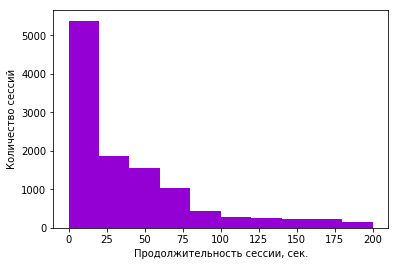

In [18]:
session_timespan = train_data_10users['session_timespan']
session_timespan = session_timespan[session_timespan <= 200]

fig, ax = plt.subplots()
ax.hist(session_timespan, color = 'darkviolet')
ax.set_xlabel(u'Продолжительность сессии, сек.')
ax.set_ylabel(u'Количество сессий');

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

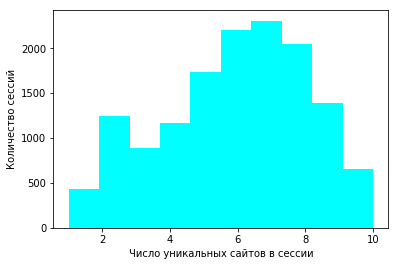

In [19]:
unique_sites = train_data_10users['#unique_sites'] 

fig, ax = plt.subplots()
ax.hist(unique_sites, color = 'aqua')
ax.set_xlabel(u'Число уникальных сайтов в сессии')
ax.set_ylabel(u'Количество сессий');

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

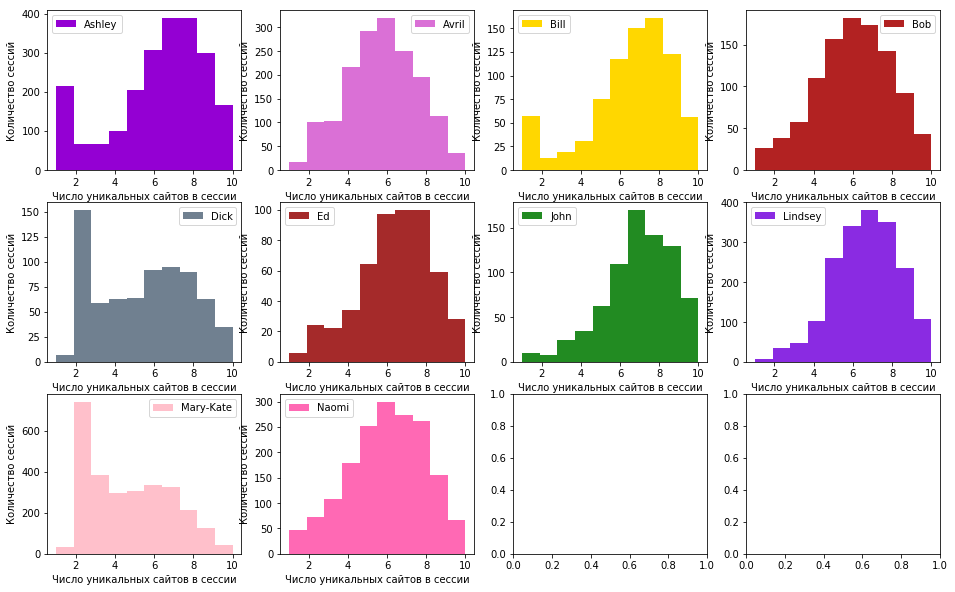

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    sp = plt.subplot(3, 4, idx+1)
    sp.hist(sub_df['#unique_sites'], color = color_dic[user])   
    sp.set_xlabel(u'Число уникальных сайтов в сессии')
    sp.axes.set_ylabel(u'Количество сессий')
    sp.axes.legend([user]);    

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

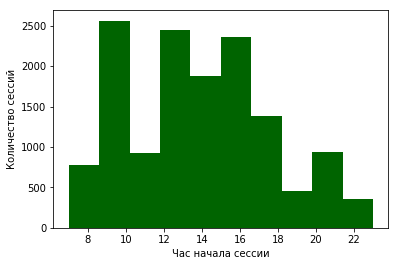

In [21]:
start_hour = train_data_10users['start_hour']

fig, ax = plt.subplots()
ax.hist(start_hour, color = 'darkgreen')
ax.set_xlabel(u'Час начала сессии')
ax.set_ylabel(u'Количество сессий');

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

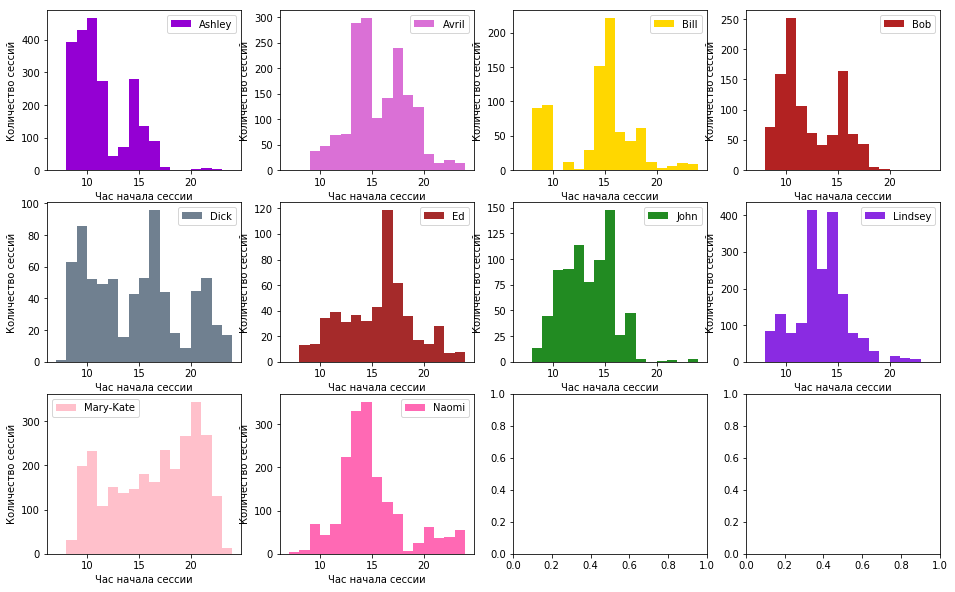

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    sp = plt.subplot(3, 4, idx+1)
    sp.hist(sub_df['start_hour'], color = color_dic[user], bins = range(7, 25))   
    sp.set_xlabel(u'Час начала сессии')
    sp.set_ylabel(u'Количество сессий')
    sp.legend([user]);    

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

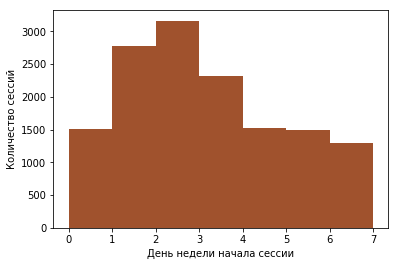

In [23]:
day_of_week = train_data_10users['day_of_week']

fig, ax = plt.subplots()
ax.hist(day_of_week, color = 'sienna', bins = range(8))
ax.set_xlabel(u'День недели начала сессии')
ax.set_ylabel(u'Количество сессий');

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

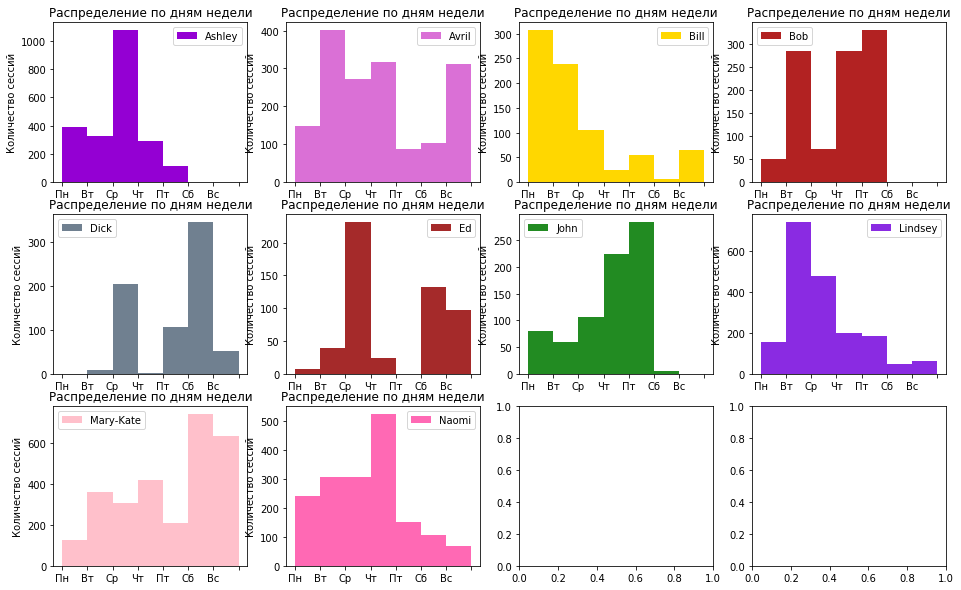

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

dow = [u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс']

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    sp = plt.subplot(3, 4, idx+1)
    _, bins, _ = sp.hist(sub_df['day_of_week'], bins = range(8), color = color_dic[user])
    sp.set_xticks(bins)
    sp.set_ylabel(u'Количество сессий')
    sp.set_title(u'Распределение по дням недели')
    sp.set_xticklabels(dow)
    sp.legend([user]);    
    

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Выводы:

Компьютеры Ashley, Bob и John, похоже, стоят в офисе, поскольку у них нет сессий в выходные дни, а также почти нет сессий в вечерние часы.

Lindsey скорее всего, тоже выходит в интернет по работе, так как в выходные и по вечерам сессий очень мало.

Avril, Dick и Mary-Kate наоборот, чаще выходят в интернет по выходным. Однако сессии Dick и Mary-Kate бывают до позднего вечера, а Avril - в основном в середине дня, вечером практически нет.

Dick и Mary-Kate отличаются тем, что у них чаще всего два сайта в сессии - очень странно, почему именно два? 

Ashley и Bill в заметной части сессий (гораздо больше, чем у других) посещают только один сайт в сессию.

Naomi и Ed отличаются от других единственным явным пиком количества сессий в середине дня - Naomi в 13-14 часов, Ed в 16. У всех остальных несколько пиков по времени дня.

Dick и Ed 2-3 рабочих дня в неделю не выходят или почти не выходят в интернет, в отличие от всех других, у кого есть сессии в каждый день или как минимум в каждый рабочий день недели.

В целом - сочетание наличия или отсутствия перечисленных особенностей уникально для каждого пользователя в выборке. 


**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей.**

In [25]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'r') as f:
    fdict10 = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [26]:
sites_by_traffic = zip(fdict10.keys(), fdict10.values())
sites_by_traffic.sort(key = lambda x: x[1][1], reverse = True)
top10 = sites_by_traffic[:10]

top10_freqs = [x[1][1] for x in top10]
top10_sites = [x[0] for x in top10]


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

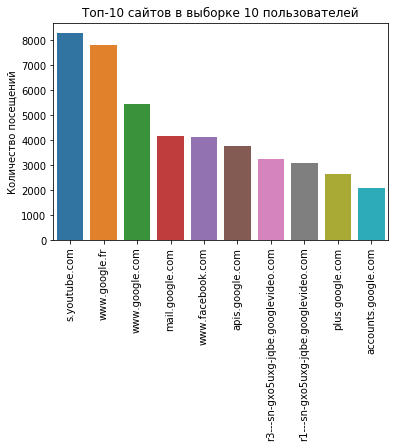

In [27]:
ax = sns.barplot(top10_sites, top10_freqs)
ax.set_ylabel(u'Количество посещений');
ax.set_title(u'Топ-10 сайтов в выборке 10 пользователей')
plt.xticks(rotation=90);

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [28]:
# Новыми признаками сессии будут:
# - год, месяц и день начала
# - рабочий день или нет
# - рабочее время суток или нет
# - индикаторы посещения топ-30 популярных сайтов

top_count = 30
top_sites = {site[1][0]:index for site, index in zip(sites_by_traffic[:top_count], range(top_count))}

new_feature_names = ['session_year',
                     'session_month',
                     'session_day',
                     'is_workday',
                     'is_worktime'] + \
                     ['top' + str(i) + 'visited' for i in range(top_count)]

# В 1-й части задания загрузка признаков была реализована с возможностью применения разных способов сбора признаков.
# Теперь просто реализуем новую функцию сбора признаков...
def more_features(sites, times, n_from, n_to):
    session_start = times[n_from]
    is_workday = 1 if session_start.dayofweek < 5 else 0
    is_worktime = 1 if session_start.hour >= 9 and session_start.hour <=19 else 0
    top_visited = [0] * top_count
    for s in sites[n_from:n_to]:
        i = top_sites.get(s)
        if not i is None:
            top_visited[i] = 1

    new_features = [session_start.year, 
                    session_start.month, 
                    session_start.day, 
                    is_workday, 
                    is_worktime] + \
                   top_visited
    
    return new_features

# ... и передадим ее параметром get_session_func в функцию prepare_train_set_with_fe()
def feature_engineering(path_to_csv_files, site_freq_path, features, session_length=10, window_size = 10):
    
    return prepare_train_set_with_fe(path_to_csv_files, site_freq_path, new_feature_names,
                                    session_length=10, window_size=10, get_session_func=features)
    


In [29]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), 
                                           os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 
                                           more_features)

CPU times: user 13.3 s, sys: 131 ms, total: 13.5 s
Wall time: 15 s


In [30]:
print(new_features_10users.shape)
new_features_10users.head()

(14061, 36)


,session_year,session_month,session_day,is_workday,is_worktime,top0visited,top1visited,top2visited,top3visited,top4visited,top5visited,top6visited,...,top19visited,top20visited,top21visited,top22visited,top23visited,top24visited,top25visited,top26visited,top27visited,top28visited,top29visited,target
0,2013,11,15,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,31
1,2013,11,15,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,31
2,2013,11,15,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,31
3,2013,11,15,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,31
4,2013,11,15,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,31


In [31]:
%%time

sites_by_traffic150 = zip(fdict10.keys(), fdict10.values())
sites_by_traffic150.sort(key = lambda x: x[1][1], reverse = True)

top_count = 30
top_sites = {site[1][0]:index for site, index in zip(sites_by_traffic150[:top_count], range(top_count))}


new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), 
                                           os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'), 
                                           more_features)

CPU times: user 2min 2s, sys: 1.14 s, total: 2min 3s
Wall time: 2min 6s


In [32]:
print(new_features_150users.shape)
new_features_150users.head()

(137019, 36)


,session_year,session_month,session_day,is_workday,is_worktime,top0visited,top1visited,top2visited,top3visited,top4visited,top5visited,top6visited,...,top19visited,top20visited,top21visited,top22visited,top23visited,top24visited,top25visited,top26visited,top27visited,top28visited,top29visited,target
0,2013,11,15,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,6
1,2013,11,15,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,6
2,2013,11,15,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,6
3,2013,11,15,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,6
4,2013,11,15,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,6


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [33]:
def draw_new_feature(feature, bins):
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

    for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
        sp = plt.subplot(3, 4, idx+1)
        sp.hist(sub_df[feature], color = color_dic[id_name_dict[user]], bins = bins)   
        sp.set_xlabel(feature)
        sp.set_ylabel(u'Количество сессий')
        sp.legend([id_name_dict[user]])   


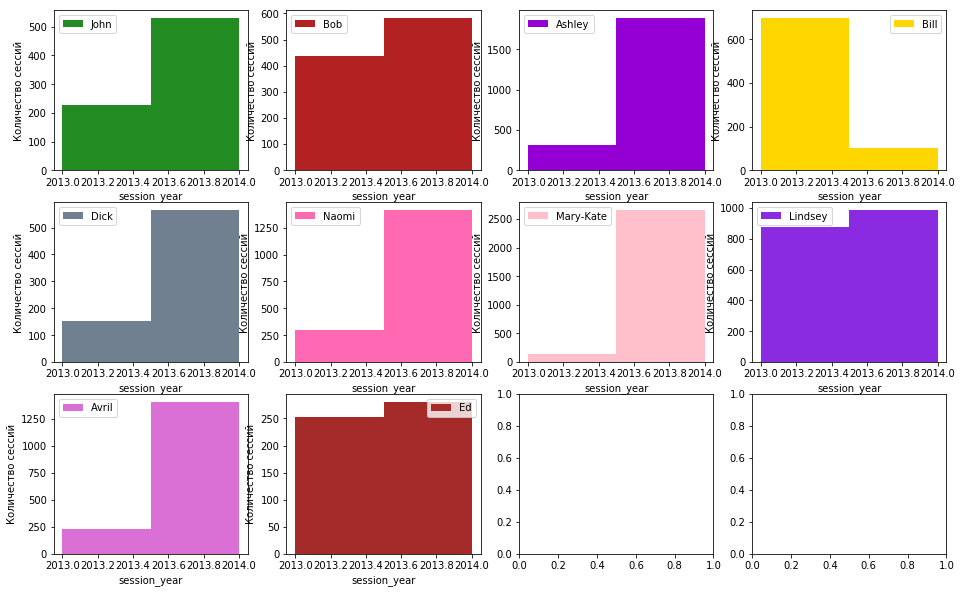

In [34]:
draw_new_feature('session_year', 2)

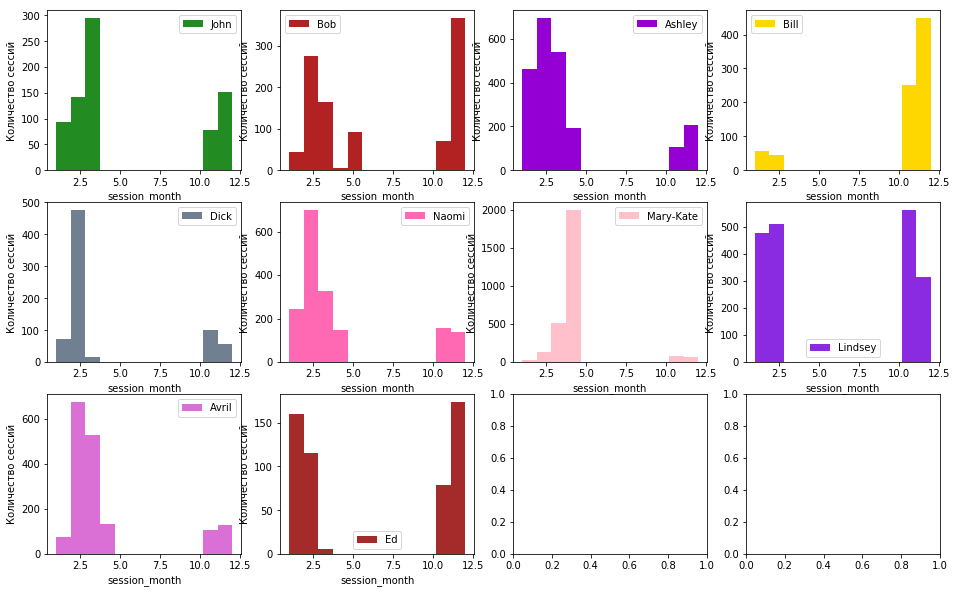

In [35]:
draw_new_feature('session_month',12)

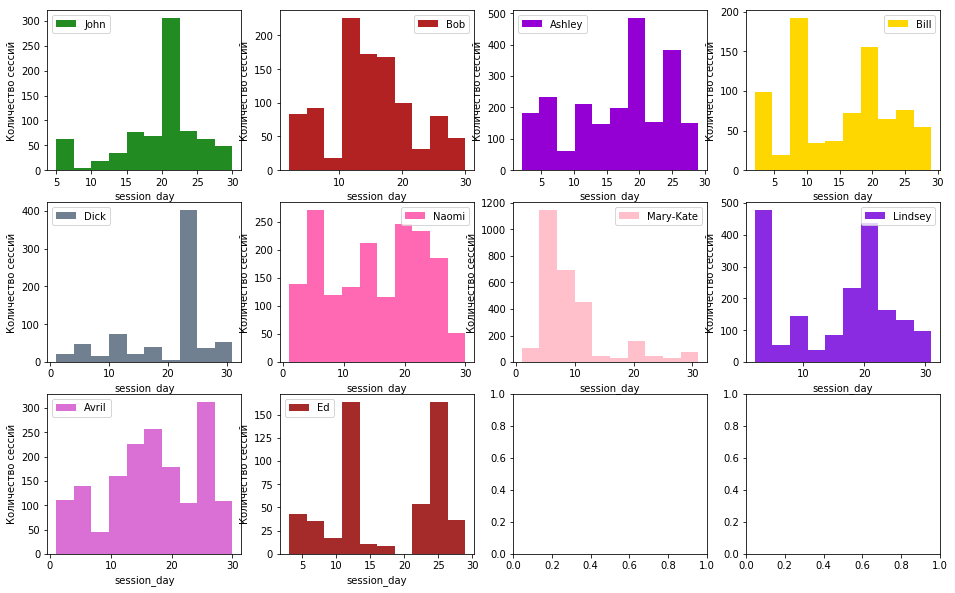

In [36]:
draw_new_feature('session_day', None)

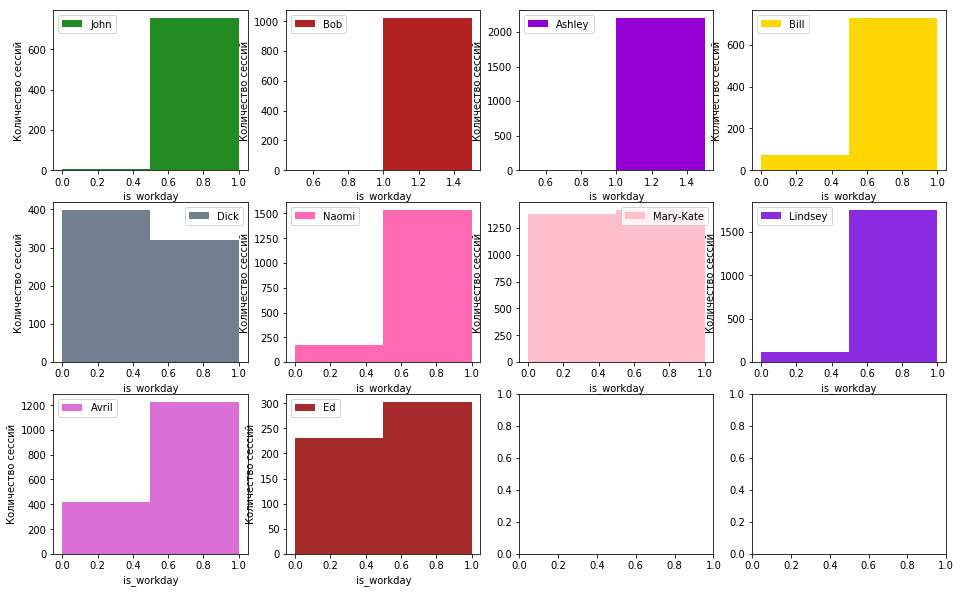

In [37]:
draw_new_feature('is_workday', 2)

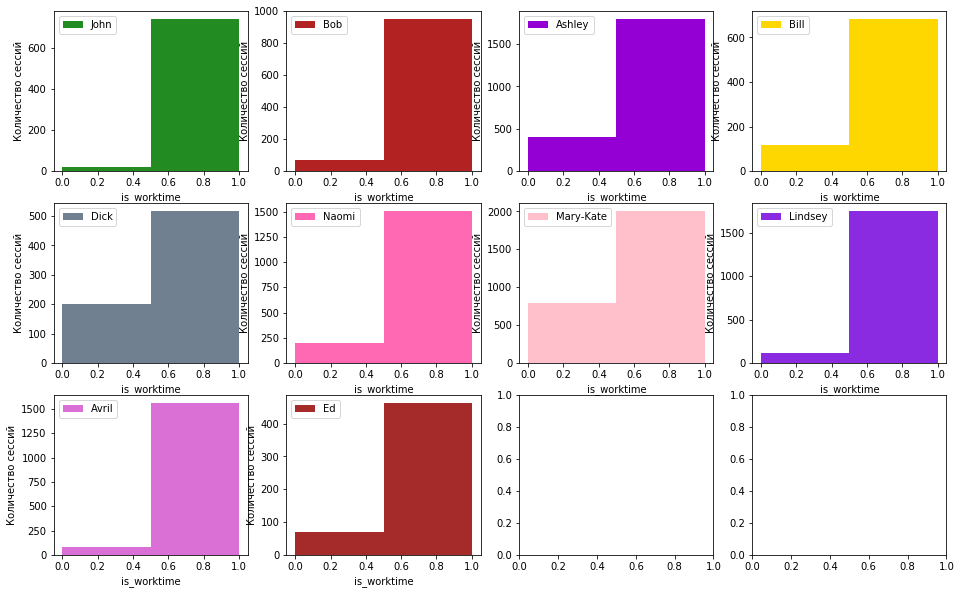

In [38]:
draw_new_feature('is_worktime', 2)

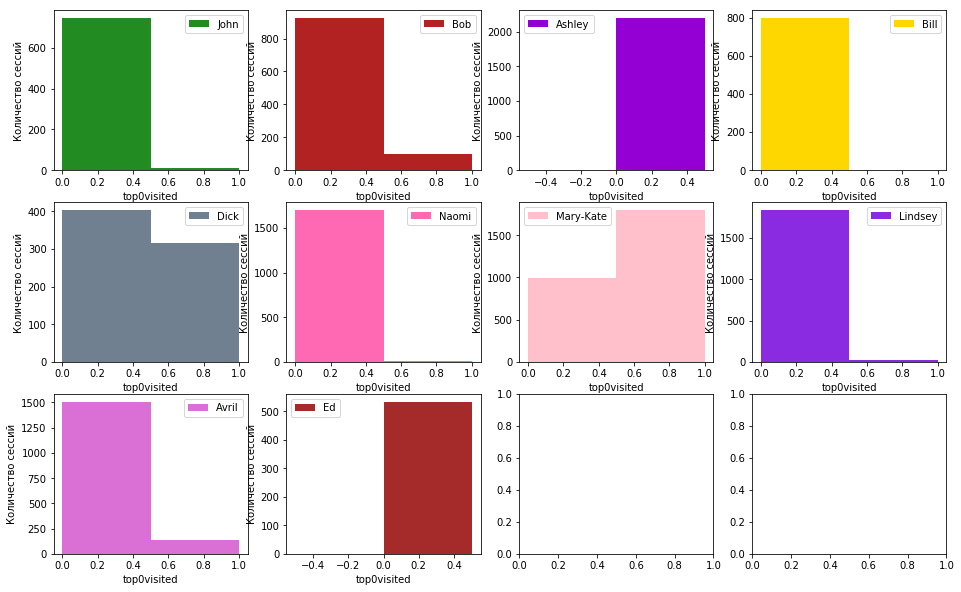

In [39]:
draw_new_feature('top0visited', 2)

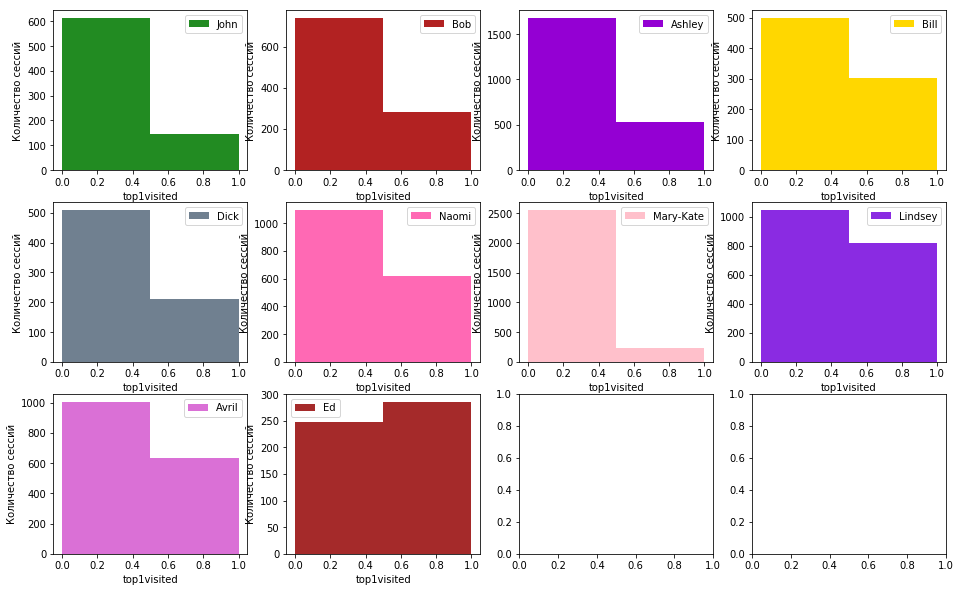

In [40]:
draw_new_feature('top1visited', 2)

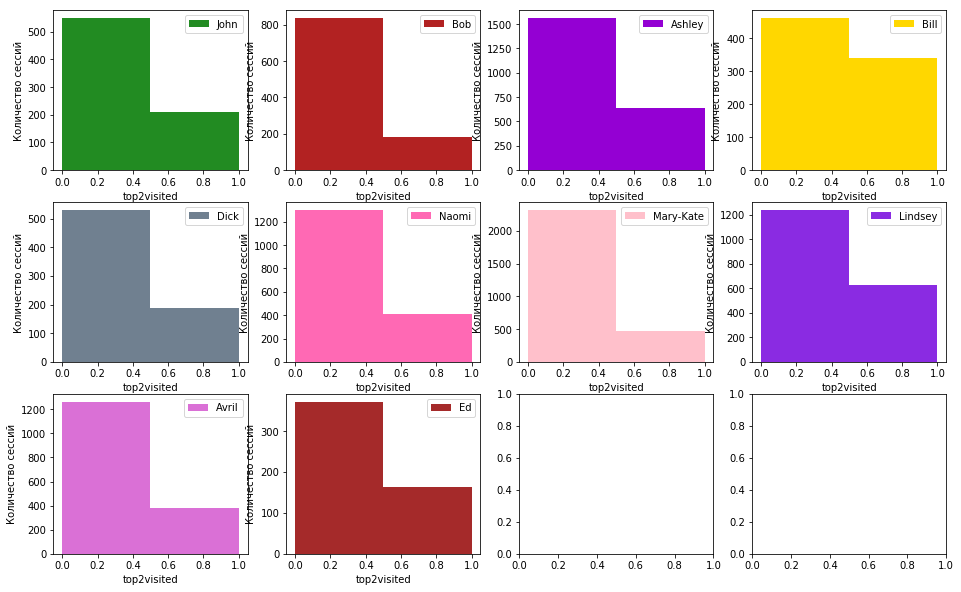

In [41]:
draw_new_feature('top2visited', 2)

### Выводы по результатам исследования новых признаков
1. Год и месяц начала сессии: различие между пользователями есть, но оно характеризует, скорее всего, не самого пользователя, а период, в течение которого собирались данные обучающей выборки. Исключаем как нерелевантный и ведущий к переобучению.
2. День начала: различие между пользователями есть, но вряд ли оно будет воспроизводиться в том же виде в данных тестовой выборки, если они будет собраны в другие периоды времени. Исключаем как нерелевантный и ведущий к переобучению. 
3. Рабочий день или нет: различие есть, но результат может быть получен линейной комбинацией признаков по дням недели (нули в субботу и воскресенье, остальные единицы). Исключаем как избыточный. 
4. Рабочее время суток или нет: различие есть, но результат может быть получен линейной комбинацией признаков по часам дня. Исключаем как избыточный.
5. Индикаторы посещения топ-30 популярных сайтов: различие есть. Но если будет использоваться модель Bag of Words по сайтам, то эти признаки ее дублируют. 

Общий вывод: среди новых признаков полезных нет, кроме разве что индикаторов посещения популярных сайтов, но и те можно использовать только для простых моделей, в которых не используется концепция Bag of Words.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [42]:
selected_old_features = feature_names  # берем все
selected_new_features = new_feature_names[-top_count:] # берем только индикаторы посещения
print(feature_names + selected_new_features) # проверим, правильно ли взяли

selected_features_10users = train_data_10users
selected_features_150users = 0

['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10', 'time_diff1', 'time_diff2', 'time_diff3', 'time_diff4', 'time_diff5', 'time_diff6', 'time_diff7', 'time_diff8', 'time_diff9', 'session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'top0visited', 'top1visited', 'top2visited', 'top3visited', 'top4visited', 'top5visited', 'top6visited', 'top7visited', 'top8visited', 'top9visited', 'top10visited', 'top11visited', 'top12visited', 'top13visited', 'top14visited', 'top15visited', 'top16visited', 'top17visited', 'top18visited', 'top19visited', 'top20visited', 'top21visited', 'top22visited', 'top23visited', 'top24visited', 'top25visited', 'top26visited', 'top27visited', 'top28visited', 'top29visited']


In [43]:
selected_features_10users = \
    train_data_10users[selected_old_features] \
    .join(new_features_10users[selected_new_features]) \
    .join(new_features_10users['target'])

print(selected_features_10users.shape)
selected_features_10users.head()

(14061, 54)


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,top19visited,top20visited,top21visited,top22visited,top23visited,top24visited,top25visited,top26visited,top27visited,top28visited,top29visited,target
0,1,2,3,4,3,3,4,3,5,3,10,0,...,0,0,0,0,0,0,0,0,0,0,0,31
1,6,7,8,9,3,10,11,12,13,14,1,0,...,0,0,0,0,0,0,0,0,0,0,0,31
2,14,4,14,14,15,16,6,17,18,14,0,14,...,0,0,0,0,0,0,0,0,0,0,0,31
3,19,20,19,14,14,14,14,21,22,23,2,1,...,0,0,0,0,0,0,0,0,0,0,0,31
4,24,14,15,25,26,27,28,29,30,29,1,0,...,0,0,0,0,0,0,0,0,0,0,0,31


In [44]:
selected_features_150users = \
    train_data_150users[selected_old_features] \
    .join(new_features_150users[selected_new_features]) \
    .join(new_features_150users['target'])

print(selected_features_150users.shape)
selected_features_150users.head()

(137019, 54)


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,top19visited,top20visited,top21visited,top22visited,top23visited,top24visited,top25visited,top26visited,top27visited,top28visited,top29visited,target
0,1,1,2,3,1,2,1,3,4,5,1,1,...,0,0,0,0,0,0,0,0,0,0,0,6
1,3,6,7,4,5,5,8,9,10,10,0,0,...,0,0,0,0,0,0,0,0,0,0,0,6
2,5,11,1,1,1,1,9,5,3,1,1,10,...,0,0,0,0,0,0,0,0,0,0,0,6
3,1,1,12,12,13,12,12,1,14,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,6
4,1,1,15,1,16,17,16,17,18,15,4,3,...,0,0,0,0,0,0,0,0,0,0,0,6


In [45]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 